Project 3: Classification

The goal of this project is to build a machine learning model to predict a category for a dataset.

For this project, I use Sonoma County's Animal Shelter Intake and Outake data to predict the likelihood an animal will be returned from adoption.

In this notebook, I save the data from Sonoma County's Animal Shelter Intake and Outake data into a pickle file, prep the data, and clean it up.

### Table of Contents
1. Imports
2. Data Collection
3. Data Cleaning and Preparation

#### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

#### 2. Data Collection

On July 20, 2020, I used Socrata's Open Data API to access Sonoma County's Animal Shelter Intake and Outake data. This data is provided by the County of Sonoma's Department of Health Services. It lists animals that are taken in, features about the animal such as type, breed, and gender, and the related intake/outake data such as condition, reason, etc.

In [5]:
# import Socrata API
from sodapy import Socrata

In [6]:
# Use Authenticated client to grab data. Fill in using a Socrata username and password
client = Socrata("data.sonomacounty.ca.gov",
                "YIJwNZXuLC7fQwZI1aclzXFAB",
                username="",
                password="")

# 924a-vews is the code for Sonoma County's animal shelter intake and outake data
results = client.get("924a-vesw", limit=19690)
animal_df = pd.DataFrame.from_records(results)

In [7]:
# Save animal_df as a pickle file
with open("data/animal_df.pickle", 'wb') as write_file:
    pickle.dump(animal_df, write_file)

#### 3. Data Cleaning and Preparation

Now that animal data is saved as a dataframe, I examine and clean it up. I'll need to check for null values and decide what to do with missing data. I also need to convert some datatype to DateTime objects for future use. As I'm cleaning the data, I will also be looking at the features and thinking about how they would fit into my classification model.

In [6]:
with open('data/animal_df.pickle', 'rb') as read_file:
    animal_df = pickle.load(read_file)

In [7]:
animal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19690 entries, 0 to 19689
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         14679 non-null  object
 1   type                         19690 non-null  object
 2   breed                        19690 non-null  object
 3   color                        19690 non-null  object
 4   sex                          19690 non-null  object
 5   size                         19659 non-null  object
 6   date_of_birth                14953 non-null  object
 7   impound_number               19690 non-null  object
 8   kennel_number                19669 non-null  object
 9   id                           19690 non-null  object
 10  intake_date                  19690 non-null  object
 11  days_in_shelter              19690 non-null  object
 12  intake_type                  19690 non-null  object
 13  intake_subtype               19

There are 19,690 rows. Many columns have 19,000+ non-null values. That means I don't need to impute too many data points. Columns that concern me are "name", which has 14,684 non-null objects and "date_of_birth", which has 14,958 non-null objects.

Additionally, all of the datatypes are objects, so I need to convert them to the appropriate types.

Time to explore my data. What kinds of values do I have? What features do I want to include in my model?

In [25]:
# The majority of animals are dogs.
animal_df["type"].value_counts()

DOG      11127
CAT       7030
OTHER     1533
Name: type, dtype: int64

In [23]:
# Six different outcome conditions
animal_df["outcome_condition"].value_counts()

HEALTHY                 12858
UNTREATABLE              2361
PENDING                  1444
TREATABLE/MANAGEABLE     1234
TREATABLE/REHAB          1192
DEAD                      299
Name: outcome_condition, dtype: int64

In [19]:
# Most outcomes are returning to owner or adoption.
animal_df["outcome_type"].value_counts()

RETURN TO OWNER    6600
ADOPTION           6284
TRANSFER           3659
EUTHANIZE          2753
DIED                134
DISPOSAL            121
ESCAPED/STOLEN       17
RTOS                  7
Name: outcome_type, dtype: int64

In [43]:
# Target feature of adoption returns is really low
animal_df["intake_type"].value_counts()

STRAY              14412
OWNER SURRENDER     2597
CONFISCATE          1404
QUARANTINE           505
TRANSFER             432
ADOPTION RETURN      340
Name: intake_type, dtype: int64

There are 6 different intake types. Initially, I was going to focus my project on which animals were adopted. However, because the large majority of pets are adopted or returned to their owner, it didn't seem like a very interesting project. Instead, I think it would be interesting to focus on animals that were returned from adoption.

Why were the pets returned from adoption? Are there certain breeds or animal sizes that are more likely to be returned? What features are associated with being returned from adoption?

Narrowing down features
* name (turn into a boolean)
* type (dog, cat, or other)
* breed (will need narrow down or exclude entirely because there are hundreds of different breeds)
* color (does this matter?)
* sex
* size
* date of birth (will need to get age from this; some may be null)
* outcome type, outcome subtype
* intake condition, outcome condition
* intake jurisdiction, outcome jurisdiction
* zip code
* location

Target variable:
* intake type: Adoption Return

Features to drop:
* impound number, kennel number, animal ID

In [8]:
# drop identification columns that aren't necessary for building my classification model
animal_df = animal_df.drop(columns=['impound_number', 'kennel_number', 'id', ':@computed_region_dig5_f3vy'])

Clean up "Sex" column:<br/>
* Currently, there are 5 different sexes: Neutered, Spayed, Male, Female, and Unknown
* male pets have been neutered
* female pets have been spayed

In [10]:
# the sex column has 5 different values, but for gender, I want 3 values: Male, Female, and Unknown
animal_df["sex"].value_counts()

Neutered    6799
Spayed      5706
Male        2994
Female      2549
Unknown     1642
Name: sex, dtype: int64

In [9]:
# Create a new gender column and specify that Neutered and Spayed are Male and Female respectively
animal_df["gender"] = animal_df["sex"].apply(lambda x: "Male" if x == "Neutered" else "Female" if x == "Spayed" else x)
animal_df["gender"].value_counts()

Male       9793
Female     8255
Unknown    1642
Name: gender, dtype: int64

In [11]:
# Create another column indicating whether the animal has been spayed or neutered
animal_df["spay_neuter"] = animal_df["sex"].apply(lambda x: 1 if x == "Neutered" else 1 if x == "Spayed" else 0)

In [12]:
# turn date columns into datetime objects
animal_df["date_of_birth"] = pd.to_datetime(animal_df["date_of_birth"], format='%Y-%m-%d')
animal_df["intake_date"] = pd.to_datetime(animal_df["intake_date"], format='%Y-%m-%d')
animal_df["outcome_date"] = pd.to_datetime(animal_df["outcome_date"], format='%Y-%m-%d')

In [6]:
# Examine animals in the "OTHER" type category. Looks like there's some rabbits, birds, and other mammals.
other_animals_list = list(zip(animal_df[animal_df["type"] == "OTHER"]["breed"].value_counts().index.to_list(), animal_df[animal_df["type"] == "OTHER"]["breed"].value_counts().values))
other_animals_list[:10]

[('RABBIT SH', 308),
 ('CHICKEN', 279),
 ('BAT', 131),
 ('GOAT', 81),
 ('GUINEA PIG', 68),
 ('SHEEP', 53),
 ('RAT', 45),
 ('HORSE', 38),
 ('PARAKEET', 35),
 ('KOI', 24)]

In [67]:
# investigating animal color
animal_color_list = animal_df["color"].value_counts().index.to_list()

In [13]:
# separate multiple colors into their own columns (Tan/White would be Color 1: Tan and Color 2: White)
animal_df["color_1"] = animal_df[animal_df["color"].str.contains('/')]["color"].str.split('/').str[0]
animal_df["color_2"] = animal_df[animal_df["color"].str.contains('/')]["color"].str.split('/').str[1]
# Fill in the first color if there was only 1 primary color
animal_df["color_1"] = animal_df["color_1"].fillna(animal_df["color"])

In [14]:
# split breed in a similar way to color
animal_df["breed_1"] = animal_df[animal_df["breed"].str.contains('/')]["breed"].str.split('/').str[0]
animal_df["breed_2"] = animal_df[animal_df["breed"].str.contains('/')]["breed"].str.split('/').str[1]
animal_df["breed_1"] = animal_df["breed_1"].fillna(animal_df["breed"])

In [15]:
# clean up names; names with an asterisk before them were given by shelter staff
animal_df["clean_name"] = animal_df["name"].str.replace('*','')

Make a boolean column for whether an animal has a name or not. 1 means the animal had a name, and a 0 means the animal didn't have a name.<br/>If the name has an asterick before the name, that means it was given by shelter staff. The animal did not have a name previously, so that animal gets a 0 in this column.

In [16]:
# make a boolean column for whether a pet had a name or not
animal_df["has_name"] = animal_df["name"].apply(lambda x: 0 if '*' in str(x) else 0 if pd.isnull(x) else 1)

In [13]:
# The size column looks fine
animal_df["size"].value_counts()

SMALL    7623
MED      3476
LARGE    3468
KITTN    3158
TOY      1021
PUPPY     713
X-LRG     200
Name: size, dtype: int64

In [12]:
# examine intake condition
animal_df["intake_condition"].value_counts()

HEALTHY                 10880
UNKNOWN                  3634
TREATABLE/REHAB          2045
UNTREATABLE              1910
TREATABLE/MANAGEABLE     1221
Name: intake_condition, dtype: int64

In [21]:
# intake subtype information is hard to interpret (What does COMM CAT mean?)
animal_df["intake_subtype"].value_counts()

OVER THE COUNTER                    7666
FIELD                               7486
COMM CAT                            1269
FLD_ARREST                           783
VET_HOSP                             627
PRIV_SHELT                           313
FLD_STRAY                            257
FLD_CRUEL                            219
FLD_HOSPTL                           201
BORN_HERE                            196
MUN_SHELT                            134
FLD_CORONR                           121
FIELD_RETURN TO OWNER                113
PHONE                                 77
FIELD_OS                              73
FLD_EVICT                             52
OVER THE COUNTER_STRAY                23
OVER THE COUNTER_OS                   19
RESCUE_GRP                            17
OVER THE COUNTER_RETURN TO OWNER      13
OVER THE COUNTER_ARREST               12
FLD_LIVSTK                             9
OVER THE COUNTER_CORONR                6
OVER THE COUNTER_EVICT                 3
OVER THE COUNTER

In [8]:
# Majority of animals that were returned from adoption were over the counter
animal_df[animal_df["intake_type"] == "ADOPTION RETURN"]["intake_subtype"].value_counts()

OVER THE COUNTER    334
FIELD                 6
Name: intake_subtype, dtype: int64

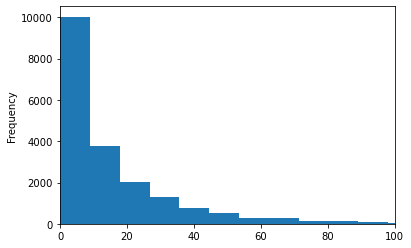

In [17]:
# Turn days in shelter into the int type. Looks like most animals spend less than 20 days in the shelter
animal_df["days_in_shelter"] = animal_df["days_in_shelter"].astype(int)
animal_df["days_in_shelter"].plot.hist(bins=100, xlim=(0,100));

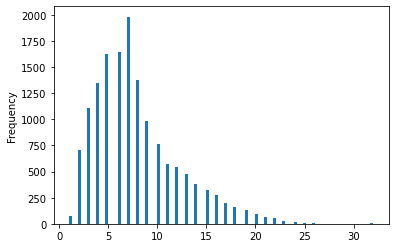

In [18]:
# Create "age" column from date of birth. Age starts from 1 to avoid potential log transformation or scaling issues
animal_df["age"] = np.where(animal_df["date_of_birth"].isnull(), np.nan, 2021-animal_df["date_of_birth"].dt.year)
animal_df["age"].plot.hist(bins=100);

Breed is a tricky feature. There are tons of different unique values. It looks like dog breeds are generally more descriptive than cat breeds (the large majority of cat breeds just lists DOMESTIC SH). I may drop this feature from my model.

In [4]:
dog_breed_list = list(zip(animal_df.loc[animal_df["type"] == "DOG", "breed"].value_counts().index.to_list(), animal_df.loc[animal_df["type"] == "DOG", "breed"].value_counts().values))
dog_breed_list[:20]

[('PIT BULL', 1514),
 ('CHIHUAHUA SH', 942),
 ('GERM SHEPHERD', 683),
 ('PIT BULL/MIX', 641),
 ('CHIHUAHUA SH/MIX', 467),
 ('LABRADOR RETR', 416),
 ('LABRADOR RETR/MIX', 295),
 ('GERM SHEPHERD/MIX', 287),
 ('SIBERIAN HUSKY', 277),
 ('PARSON RUSS TER/MIX', 188),
 ('BORDER COLLIE/MIX', 146),
 ('PARSON RUSS TER', 121),
 ('ROTTWEILER', 112),
 ('CAIRN TERRIER/MIX', 104),
 ('BORDER COLLIE', 101),
 ('POODLE MIN/MIX', 94),
 ('POODLE MIN', 93),
 ('SHIH TZU', 92),
 ('AUST SHEPHERD/MIX', 71),
 ('AUST CATTLE DOG', 69)]

In [5]:
cat_breed_list = list(zip(animal_df.loc[animal_df["type"] == "CAT", "breed"].value_counts().index.to_list(), animal_df.loc[animal_df["type"] == "CAT", "breed"].value_counts().values))
cat_breed_list[:20]

[('DOMESTIC SH', 5415),
 ('DOMESTIC MH', 642),
 ('DOMESTIC LH', 570),
 ('SIAMESE', 149),
 ('SIAMESE/MIX', 116),
 ('HIMALAYAN', 17),
 ('MANX', 16),
 ('HIMALAYAN/MIX', 9),
 ('BENGAL', 9),
 ('SNOWSHOE/MIX', 8),
 ('PERSIAN', 7),
 ('SNOWSHOE', 6),
 ('MANX/MIX', 6),
 ('ABYSSINIAN/MIX', 4),
 ('DOMESTIC LH/SIAMESE', 3),
 ('MAINE COON', 3),
 ('DOMESTIC LH/MAINE COON', 3),
 ('SCOTTISH FOLD/MIX', 3),
 ('PERSIAN/MIX', 3),
 ('DOMESTIC SH/MIX', 3)]

In [6]:
other_breed_list = list(zip(animal_df.loc[animal_df["type"] == "OTHER", "breed"].value_counts().index.to_list(), animal_df.loc[animal_df["type"] == "OTHER", "breed"].value_counts().values))
other_breed_list[:20]

[('RABBIT SH', 308),
 ('CHICKEN', 279),
 ('BAT', 131),
 ('GOAT', 81),
 ('GUINEA PIG', 68),
 ('SHEEP', 53),
 ('RAT', 45),
 ('HORSE', 38),
 ('PARAKEET', 35),
 ('KOI', 24),
 ('PIG', 21),
 ('COCKATIEL', 20),
 ('LOP-MINI', 19),
 ('PEAFOWL', 17),
 ('HAMSTER', 16),
 ('GOOSE', 15),
 ('DUCK', 14),
 ('PIGEON', 14),
 ('ENGLISH SPOT/MIX', 13),
 ('REX', 13)]

In [7]:
# Briefly looking into what animals have been returned from adoption
adopt_return_df = animal_df[animal_df["intake_type"] == "ADOPTION RETURN"]
adopt_return_df.head()

,name,type,breed,color,sex,size,date_of_birth,intake_date,days_in_shelter,intake_type,...,spay_neuter,color_1,color_2,breed_1,breed_2,age,top_breeds,top_colors,adopt_return,has_name
374,SHADOW,DOG,GERM SHEPHERD,BLACK/BROWN,Neutered,LARGE,2018-04-10,2019-10-22,18,ADOPTION RETURN,...,1,BLACK,BROWN,GERM SHEPHERD,NaN,3.0,GERM SHEPHERD,OTHER,1,1
397,*KENNY,CAT,DOMESTIC SH,BLACK,Neutered,KITTN,2016-05-26,2016-10-25,1,ADOPTION RETURN,...,1,BLACK,NaN,DOMESTIC SH,NaN,5.0,DOMESTIC SH,BLACK,1,0
447,*NIKKI,DOG,YORKSHIRE TERR/MIX,BLACK/GRAY,Spayed,TOY,2013-11-21,2017-11-21,1,ADOPTION RETURN,...,1,BLACK,GRAY,YORKSHIRE TERR,MIX,8.0,OTHER,OTHER,1,0
476,PRINCESS,DOG,CHIHUAHUA SH/MIX,TAN/WHITE,Spayed,PUPPY,2016-08-13,2017-03-31,8,ADOPTION RETURN,...,1,TAN,WHITE,CHIHUAHUA SH,MIX,5.0,CHIHUAHUA SH/MIX,TAN/WHITE,1,1
496,*COLE,DOG,CAIRN TERRIER/YORKSHIRE TERR,BROWN/BLACK,Neutered,SMALL,2017-07-01,2020-01-03,0,ADOPTION RETURN,...,1,BROWN,BLACK,CAIRN TERRIER,YORKSHIRE TERR,4.0,OTHER,OTHER,1,0


In [8]:
# Are there any common breeds that are returned from adoption?
adopt_return_list = list(zip(adopt_return_df["breed"].value_counts().index.to_list(), adopt_return_df["breed"].value_counts().values))
adopt_return_list[:10]

[('DOMESTIC SH', 76),
 ('PIT BULL', 31),
 ('CHIHUAHUA SH', 21),
 ('PIT BULL/MIX', 15),
 ('GERM SHEPHERD', 15),
 ('CHIHUAHUA SH/MIX', 11),
 ('DOMESTIC LH', 8),
 ('GERM SHEPHERD/MIX', 7),
 ('PARSON RUSS TER/MIX', 5),
 ('POMERANIAN/ITAL GREYHOUND', 4)]

In [36]:
# there are 112 unique breeds of animals that have been returned from adoption
print(len(adopt_return_list))

112


In [39]:
# The good news is that most animals that are returned from adoption are adopted again.
adopt_return_df["outcome_type"].value_counts()

ADOPTION           260
TRANSFER            46
EUTHANIZE           29
RETURN TO OWNER      4
DIED                 1
Name: outcome_type, dtype: int64

In [42]:
# Are there particular counties that have higher adoption return rates?
adopt_return_df["intake_jurisdiction"].value_counts()

SANTA ROSA       165
COUNTY            87
*WINDSOR          25
OUT OF COUNTY     22
*ROHNERT PARK     15
*HEALDSBURG       12
*PETALUMA          6
*CLOVERDALE        5
*SONOMA            1
*SEBASTOPOL        1
*COTATI            1
Name: intake_jurisdiction, dtype: int64

I have some categorical variables. For some models, I'll need to make dummy variables. This means I'll need to drop one column. I'll run a quick and dirty logistic regression and look at what features have higher beta coefficients. I need to make sure that I include those in my model.

In [19]:
animal_df[["type", "breed", "color", "gender", "intake_jurisdiction", "intake_subtype"]].nunique()

type                     3
breed                  933
color                  315
gender                   3
intake_jurisdiction     13
intake_subtype          25
dtype: int64

Now, I want to use LogisticRegression to help me do feature selection. Which features have the highest coefficients?

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
categorical_columns = ["type", "breed", "color", "gender", "intake_jurisdiction", "intake_subtype"]
coefficient_dict = {}

for column in categorical_columns:
    logreg = LogisticRegression()
    x = pd.get_dummies(animal_df[column])
    y = animal_df["adopt_return"]
    logreg.fit(x, y)
    
    #grab the coefficients
    coefs = logreg.coef_[0]
    
    # get index of array that would sort the array from lowest to highest coefficients
    idx = coefs.argsort()
    
    # correlate index to features. The features will be sorted from lowest to highest coefficients
    feature_list = [x.columns[i] for i in idx]
    
    # grab the top 10 features with the highest coefficients
    top_features = feature_list[-10:]
    coefficient_dict[column] = top_features

In [12]:
coefficient_dict

{'type': ['OTHER', 'CAT', 'DOG'],
 'breed': ['DUTCH SHEPHERD/MIX',
  'TR WALKER HOUND/MIX',
  'BLACK MOUTH CUR/MIX',
  'MASTIFF/MIX',
  'VIZSLA/MIX',
  'BULL TERRIER/MIX',
  'RHOD RIDGEBACK/LABRADOR RETR',
  'GERM SHEPHERD/CHOW CHOW',
  'CAROLINA DOG',
  'POMERANIAN/ITAL GREYHOUND'],
 'color': ['TAN/BLACK',
  'WHITE/ORG TABBY',
  'FAWN',
  'CALICO/BRN TABBY',
  'BR BRINDLE/WHITE',
  'CHOCOLATE/TAN',
  'BLUE/FAWN',
  'LILAC PT/WHITE',
  'BLK SMOKE',
  'FAWN/WHITE'],
 'gender': ['Unknown', 'Male', 'Female'],
 'intake_jurisdiction': ['*SONOMA',
  '*TRIBAL RESV',
  'UNKNOWN',
  '*SEBASTOPOL',
  '*PETALUMA',
  '*COTATI',
  'OUT OF COUNTY',
  '*CLOVERDALE',
  '*HEALDSBURG',
  '*ROHNERT PARK'],
 'intake_subtype': ['OVER THE COUNTER_STRAY',
  'OVER THE COUNTER_OS',
  'RESCUE_GRP',
  'OVER THE COUNTER_RETURN TO OWNER',
  'OVER THE COUNTER_ARREST',
  'FLD_LIVSTK',
  'OVER THE COUNTER_CORONR',
  'OVER THE COUNTER_EVICT',
  'OVER THE COUNTER_OWNED',
  'OVER THE COUNTER']}

In [107]:
# calculating the percentage 
adopt_return_ratio_dict = {}

for k, v in coefficient_dict.items():
    for value in v:
        if len(animal_df.loc[animal_df[k] == value, "adopt_return"].value_counts().values) > 1:
            adopt_return_ratio = (animal_df.loc[animal_df[k] == value, "adopt_return"]
                                  .value_counts().values[1]/
                                  animal_df[animal_df[k] == value].shape[0]
                                 )
            total_count = animal_df[animal_df[k] == value].shape[0]
            # if people return this animal with a 0.15 ratio or greater, add it to the dictionary
            if adopt_return_ratio > 0.15:
                adopt_return_ratio_dict[value] = (f"Adopt Return Ratio: {round(adopt_return_ratio, 2)}, Count:{total_count}")

In this dictionary, there are 6 total dogs with the breed BORDER COLLIE/PIT BULL. It had an adoption return ratio of 0.17. That seems high, but that's because the sample size is so small.

In [108]:
adopt_return_ratio_dict

{'BORDER COLLIE/PIT BULL': 'Adopt Return Ratio: 0.17, Count:6',
 'GERM SHEPHERD/BELG MALINOIS': 'Adopt Return Ratio: 0.17, Count:6',
 'MANX/MIX': 'Adopt Return Ratio: 0.17, Count:6',
 'PIT BULL/CATAHOULA': 'Adopt Return Ratio: 0.2, Count:5',
 'DACHSHUND/PARSON RUSS TER': 'Adopt Return Ratio: 0.2, Count:5',
 'FLAT COAT RETR/MIX': 'Adopt Return Ratio: 0.2, Count:5',
 'PLOTT HOUND': 'Adopt Return Ratio: 0.2, Count:5',
 'MASTIFF/PIT BULL': 'Adopt Return Ratio: 0.25, Count:4',
 'TOY FOX TERRIER': 'Adopt Return Ratio: 0.25, Count:4',
 'HOTOT/MIX': 'Adopt Return Ratio: 0.25, Count:4',
 'CHIHUAHUA SH/BEAGLE': 'Adopt Return Ratio: 0.25, Count:4',
 'FOX TERR SMOOTH/BEAGLE': 'Adopt Return Ratio: 0.25, Count:4',
 'LABRADOR RETR/MALTESE': 'Adopt Return Ratio: 0.25, Count:4',
 'BEAGLE/CHIHUAHUA SH': 'Adopt Return Ratio: 0.33, Count:3',
 'NEW ZEALAND WHT': 'Adopt Return Ratio: 0.33, Count:3',
 'STAFFORDSHIRE/MIX': 'Adopt Return Ratio: 0.33, Count:3',
 'POODLE MIN/BICHON FRISE': 'Adopt Return Ratio: 0

In [43]:
# the most often returned breed is Domestic SH, then pit bulls
animal_df.loc[animal_df["adopt_return"] == 1,"breed"].value_counts()

DOMESTIC SH                  76
PIT BULL                     31
CHIHUAHUA SH                 21
PIT BULL/MIX                 15
GERM SHEPHERD                15
                             ..
MASTIFF/PIT BULL              1
HOTOT/MIX                     1
PBGV/MIX                      1
DACHSHUND/PARSON RUSS TER     1
BORDER COLLIE/PIT BULL        1
Name: breed, Length: 112, dtype: int64

In [19]:
# create a column for the top 10 breeds and top 10 colors just in case
top_breeds = animal_df["breed"].value_counts().index[:10]
top_colors = animal_df["color"].value_counts().index[:10]
animal_df["top_breeds"] = animal_df["breed"].apply(lambda x: x if x in top_breeds else "OTHER")
animal_df["top_colors"] = animal_df["color"].apply(lambda x: x if x in top_colors else "OTHER")

In [20]:
animal_df.head()

,name,type,breed,color,sex,size,date_of_birth,intake_date,days_in_shelter,intake_type,...,spay_neuter,color_1,color_2,breed_1,breed_2,clean_name,has_name,age,top_breeds,top_colors
0,NICO,DOG,POMERANIAN,BROWN,Male,MED,2016-02-01,2020-07-12,0,STRAY,...,0,BROWN,NaN,POMERANIAN,NaN,NICO,1,5.0,OTHER,BROWN
1,NaN,DOG,PIT BULL/MIX,BLACK/WHITE,Female,MED,NaT,2020-07-12,0,STRAY,...,0,BLACK,WHITE,PIT BULL,MIX,NaN,0,NaN,PIT BULL/MIX,BLACK/WHITE
2,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaT,2020-01-19,4,STRAY,...,0,BLACK,TAN,GERM SHEPHERD,NaN,SKY,1,NaN,GERM SHEPHERD,BLACK/TAN
3,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,2015-04-06,2017-08-30,35,STRAY,...,1,TRICOLOR,NaN,BEAGLE,NaN,COCO,1,6.0,OTHER,OTHER
4,SUZIE,DOG,LABRADOR RETR/MIX,BLACK,Spayed,LARGE,2011-01-23,2015-01-07,17,STRAY,...,1,BLACK,NaN,LABRADOR RETR,MIX,SUZIE,1,10.0,OTHER,BLACK


Doing more research. Like many other counties in California, there is [mandatory sterilizatio](https://www.dogsbite.org/legislating-dangerous-dogs-california.php) of pit bulls in Sonoma County. Additionally, pit bulls are one of the most stigmatized dog breeds in America and are infamous for their aggressive behavior. Does being a pit bull mean an animal is more likely to be returned?

Sec. 5-171 on Sonoma County Municipal code states:
```
Sec. 5-171. - Mandatory spay and neutering of all pit bulls.

No person shall own, harbor or keep within the unincorporated area of this county, a pit bull over the age of four months, which has not been spayed or neutered, except as provided in Section 5-170 (a)-(g), above.
```

I'll include a new column in my dataframe indicating whether an animal is a pit bull or not.

In [21]:
animal_df["pit_bull"] = animal_df["breed"].apply(lambda x: 1 if "PIT BULL" in str(x) else 0)

Final bits of data cleaning. I also want to examine my features split by my target feature. Create a new column for adoption returns where a 1 means the animal was returned from adoption and a 0 stands for all other values.

In [23]:
# do a bit more cleaning and rename KITTN to KITTEN
animal_df.loc[animal_df["size"] == "KITTN", "size"] = "KITTEN"

# make a new column for my target feature
animal_df["adopt_return"] = animal_df["intake_type"].apply(lambda x: 1 if x == "ADOPTION RETURN" else 0)

# clean up intake_jurisdiction column
animal_df["intake_location"] = animal_df["intake_jurisdiction"].apply(lambda x: x.replace('*',''))
animal_df.loc[animal_df["intake_location"] == "COUNTY", "intake_location"] = "SONOMA COUNTY"

In [25]:
# Save animal_df as a pickle file
animal_df.to_pickle("data/animal_cleaned_df.pickle")

In [2]:
# Open the latest cleaned animal_df
with open("data/animal_cleaned_df.pickle", 'rb') as read_file:
    animal_df = pickle.load(read_file)